In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
import pysindy as ps
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sindy_utils import sindy_simulate
from functions import Rossler, Solution, jacobian, plot
from ae import Autoencoder

In [23]:
a, b, c = 0.15, 0.2, 10
h = np.pi/100
t = np.arange(0,100,h)
n = len(t)
x0 =np.array([0,1,0])
xs,ys,zs = Solution(Rossler, x0, t, [a,b,c])
tau = 20

(3184,)


In [24]:
v1 = np.array(xs[0: n - 2*tau]) #x(t)
v2 = np.array(xs[tau: n - tau]) #x(t + τ)
v3 = np.array(xs[2*tau: n]) #x(t + 2τ)

dv1 = np.gradient(v1, t[:len(v1)])
dv2 = np.gradient(v2, t[:len(v1)])
dv3 = np.gradient(v3, t[:len(v1)])

In [25]:
torch.manual_seed(123)

In [26]:
v = torch.tensor(np.array([v1, v2, v3]), dtype=torch.float32, requires_grad=True).T
dvdt = torch.tensor(np.array([dv1, dv2, dv3]), dtype=torch.float32, requires_grad=True).T
input_dim = 3
latent_dim = 3
autoencoder = Autoencoder(tau, l={'l1': 1, 'l2': 1, 'l3': 0, 'l4': 0, 'l5': 0, 'l6': 0, 'l_rossler': 0})
learning_rate = 1e-2
num_epochs = 1000
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

In [27]:
for epoch in range(num_epochs):
    Loss = autoencoder.loss(v, dvdt, criterion)
    optimizer.zero_grad()
    Loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {Loss.item():.4f}')

Epoch [100/1000], Loss: 0.2260
Epoch [200/1000], Loss: 0.1367
Epoch [300/1000], Loss: 0.0920
Epoch [400/1000], Loss: 0.0100
Epoch [500/1000], Loss: 0.0039
Epoch [600/1000], Loss: 0.0034
Epoch [700/1000], Loss: 0.0023
Epoch [800/1000], Loss: 0.0024
Epoch [900/1000], Loss: 0.0017
Epoch [1000/1000], Loss: 0.0055


In [28]:
autoencoder.eval() 
latent_variables = autoencoder.encode(v) 

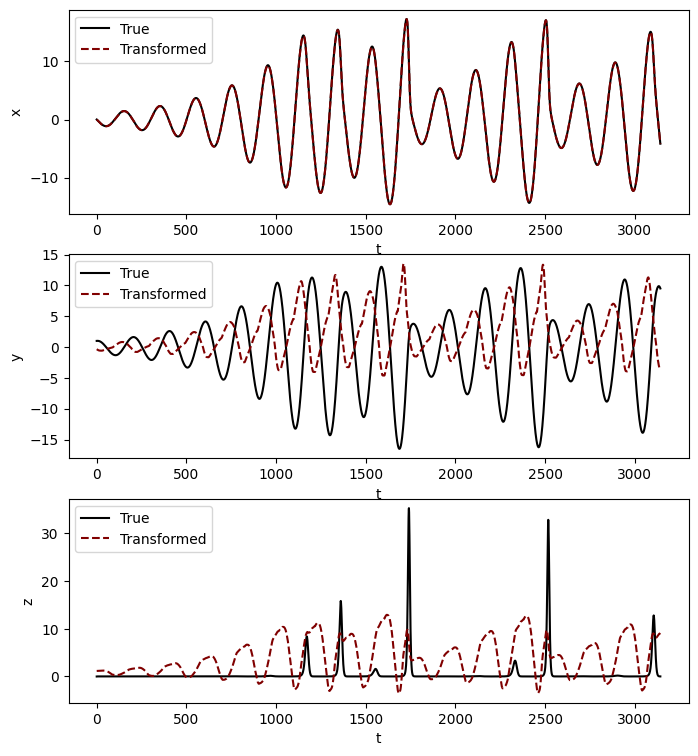

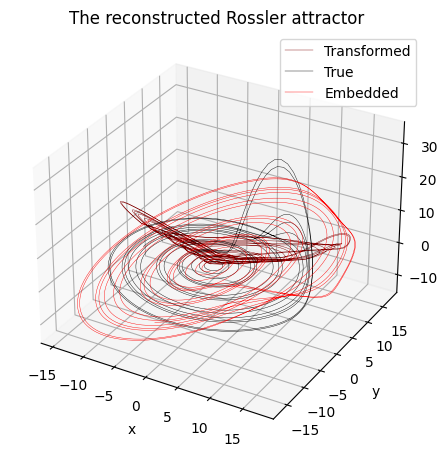

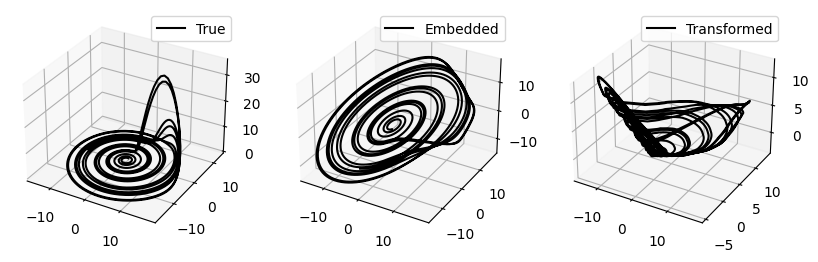

In [29]:
x_ae = latent_variables[:,0].detach().numpy()
y_ae = latent_variables[:,1].detach().numpy()
z_ae = latent_variables[:,2].detach().numpy()

plot(xs, ys, zs, v1, v2, v3, x_ae, y_ae, z_ae)